In [1]:
# ********************************************************************************
# IMPORTANT: BEFORE RUNNING THIS CELL, PERFORM A "FACTORY RESET RUNTIME" (Colab)
# OR THE EQUIVALENT DEEPEST RESTART IN YOUR ENVIRONMENT (e.g., Kaggle Session Restart).
# THEN, RUN THIS CELL AS THE VERY FIRST CODE IN YOUR NOTEBOOK.
# ********************************************************************************
!pip install -U scikit-learn==1.3.2 imbalanced-learn==0.12.3 xgboost==2.0.3
import pandas as pd
import numpy as np
import os
from collections import Counter
import ast
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json
import xgboost as xgb
import gc

# Now, the imports should work if the environment is truly clean
try:
    from imblearn.over_sampling import SMOTE
    print("\nSuccessfully imported SMOTE.")
except ImportError as e:
    print(f"\nCRITICAL ERROR: Failed to import SMOTE even after aggressive reinstallation: {e}")
    print("This indicates a severe, persistent environment issue.")
    print("Please double-check that you performed a 'Factory reset runtime' (Colab) or equivalent.")
    exit()

# 1. Inspect and Load GeoJSON Files (Modified for Zero Imputation)
data_dir = "/kaggle/input/mar-oct"  # Replace with your folder path
all_features = []
all_labels = []
invalid_samples = []
invalid_bands = Counter()
species_counts = Counter()

# Updated bands list to include all relevant bands
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'EVI', 'SAVI', 'NDWI', 'DEM']
months = ['', '_1', '_2', '_3', '_4', '_5', '_6', '_7']
band_columns = [band + month for month in months for band in bands]

# Inspect first file
first_file = os.path.join(data_dir, os.listdir(data_dir)[0]) if os.listdir(data_dir) else None
if first_file and first_file.endswith(".geojson"):
    gdf = gpd.read_file(first_file)
    print("Inspecting first 2 rows of first GeoJSON file:")
    for idx in range(min(2, len(gdf))):
        print(f"\nRow {idx}:")
        for band in ['B1', 'B2', 'B11', 'NDVI', 'DEM', 'B2_1', 'NDVI_7']:
            if band in gdf.columns:
                data = gdf[band].iloc[idx]
                try:
                    parsed_data = ast.literal_eval(data) if isinstance(data, str) else data
                    array = np.array(parsed_data, dtype=np.float32)
                    print(f"  Band {band}: shape={array.shape}, first few values={array.flatten()[:5]}")
                except (ValueError, SyntaxError, TypeError) as e:
                    print(f"  Band {band}: Error parsing/converting: {e}")
            else:
                print(f"  Band {band}: Not found in GeoJSON file")

# Load all GeoJSON files
total_samples_attempted = 0
for file in os.listdir(data_dir):
    if file.endswith(".geojson"):
        try:
            gdf = gpd.read_file(os.path.join(data_dir, file))
            print(f"Processing file: {file}, Rows: {len(gdf)}")
            total_samples_attempted += len(gdf)
            for idx, row in gdf.iterrows():
                try:
                    patch = []
                    for col in band_columns:
                        if col not in gdf.columns:
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)  # Impute with zeros
                            patch.append(array)
                            continue
                        data = row[col]
                        if data is None or (isinstance(data, str) and data.lower() == 'none'):
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)  # Impute with zeros
                            patch.append(array)
                            continue
                        try:
                            parsed_data = ast.literal_eval(data) if isinstance(data, str) else data
                            array = np.array(parsed_data, dtype=np.float32).reshape(5, 5)
                        except (ValueError, SyntaxError, TypeError) as e:
                            invalid_bands[col] += 1
                            array = np.zeros((5, 5), dtype=np.float32)  # Impute for parsing errors
                            patch.append(array)
                            continue
                        patch.append(array)
                    patch = np.stack(patch, axis=-1)
                    if patch.shape != (5, 5, 136):  # Expected shape: 17 bands * 8 months
                        raise ValueError(f"Unexpected patch shape: {patch.shape}")
                    all_features.append(patch)
                    all_labels.append(row['l3_species'])
                    species_counts[row['l3_species']] += 1
                except (ValueError, SyntaxError, TypeError) as e:
                    invalid_samples.append((file, idx, str(e)))
                    continue
        except Exception as e:
            print(f"Failed to process file {file}: {e}")
            continue

# Log invalid samples and bands
print(f"\nTotal samples attempted: {total_samples_attempted}")
print(f"Valid samples processed: {len(all_features)}")
if invalid_samples:
    print(f"\nSkipped {len(invalid_samples)} invalid samples:")
    for file, idx, error in invalid_samples:
        print(f"File: {file}, Row: {idx}, Error: {error}")
if invalid_bands:
    print("\nBands with None or missing values:")
    for band, count in invalid_bands.most_common():
        print(f"  {band}: {count} times")
print("\nValid samples per species:")
for species, count in species_counts.most_common():
    print(f"  {species}: {count}")

# Convert to NumPy arrays
if not all_features:
    print("\nError: No valid samples loaded. Using Random Forest with dummy data.")
    X_dummy = np.random.rand(100, 5*5*136)  # Updated for 136 channels
    y_dummy = np.random.randint(0, 5, 100)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_dummy, y_dummy)
    print("Random Forest dummy accuracy:", rf.score(X_dummy, y_dummy))
    print("Please re-export data with updated GEE code.")
    exit()

X = np.array(all_features, dtype=np.float32)  # Shape: (N, 5, 5, 136)
y = np.array(all_labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.

Successfully imported SMOTE.
Inspecting first 2 rows of first GeoJSON file:

Row 0:
  Band B1: shape=(5, 5), first few values=[0.1118 0.1158 0.1158 0.1158 0.1158]
  Band B2: shape=(5, 5), first few value

2025-07-17 12:30:54.212419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752755454.402508      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752755454.460416      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Data shapes: Train=(71668, 5, 5, 136), Val=(5686, 5, 5, 136), Test=(5687, 5, 5, 136)
Number of classes: 19


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752755477.655900      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/100


I0000 00:00:1752755486.880083      68 service.cc:148] XLA service 0x7bbe50014e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752755486.880867      68 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752755487.377172      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


  39/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1099 - loss: 3.4320

I0000 00:00:1752755490.673321      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1120/1120 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.4565 - loss: 1.8324 - val_accuracy: 0.6257 - val_loss: 1.2053 - learning_rate: 1.0000e-04
Epoch 2/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6921 - loss: 0.9779 - val_accuracy: 0.6549 - val_loss: 1.0851 - learning_rate: 1.0000e-04
Epoch 3/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7518 - loss: 0.7884 - val_accuracy: 0.6683 - val_loss: 1.0478 - learning_rate: 1.0000e-04
Epoch 4/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7843 - loss: 0.6670 - val_accuracy: 0.6938 - val_loss: 0.9895 - learning_rate: 1.0000e-04
Epoch 5/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8070 - loss: 0.5919 - val_accuracy: 0.7033 - val_loss: 0.9696 - learning_rate: 1.0000e-04
Epoch 6/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8269 - loss: 0.5233 - val_accuracy: 0.7003 - val_loss: 0.9913 - learning_rate: 1.0000e-04
Epoch 7/100
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - 

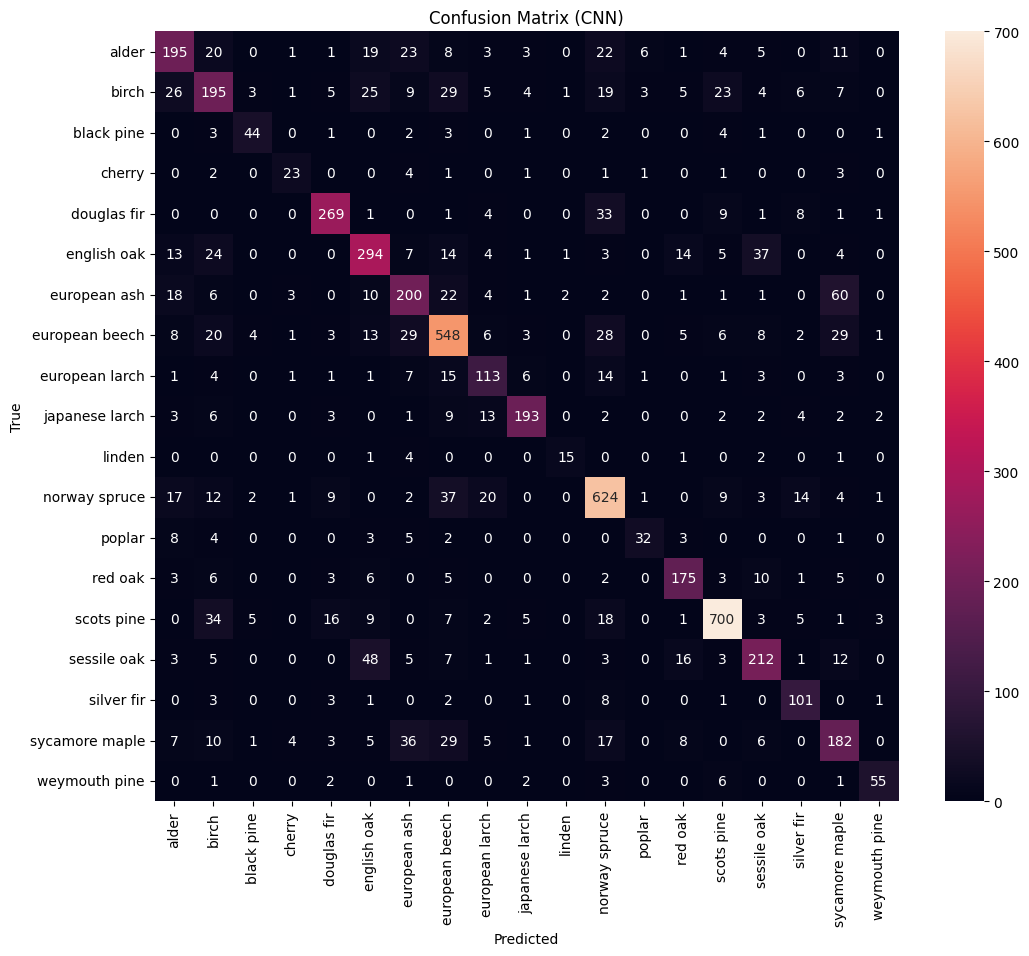

['scaler.pkl']

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 2. Flatten X for SMOTE
X_flat = X.reshape(X.shape[0], -1)

# 3. Split original data into train and temp (val + test)
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    X_flat, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# 4. Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_raw, y_train_raw)

# 5. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_temp_scaled = scaler.transform(X_temp)

# 6. Split temp into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp_scaled, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 7. Reshape back to 4D for CNN input
def reshape_for_cnn(X):
    return X.reshape(-1, 5, 5, 136)  # Assuming original shape was (5,5,136)

X_train_final = reshape_for_cnn(X_train_scaled)
X_val_final = reshape_for_cnn(X_val)
X_test_final = reshape_for_cnn(X_test)

# 8. One-hot encode labels
y_train_final = tf.keras.utils.to_categorical(y_train_resampled)
y_val_final = tf.keras.utils.to_categorical(y_val)
y_test_final = tf.keras.utils.to_categorical(y_test)

num_classes = len(label_encoder.classes_)

print(f"Data shapes: Train={X_train_final.shape}, Val={X_val_final.shape}, Test={X_test_final.shape}")
print(f"Number of classes: {num_classes}")

# 9. Compute class weights from resampled training labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# 10. Define CNN Model
def build_cnn(input_shape=(5, 5, 136), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 11. Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
])

# 12. Train Model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(
    data_augmentation(X_train_final), y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
        lr_scheduler
    ]
)

# 13. Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# 14. Additional Metrics
y_pred = model.predict(X_test_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_final, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

# 15. Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (CNN)')
plt.show()

# 16. Save Label Encoder and Scaler
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')


In [3]:
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Save the trained Keras model
model.save('model1.keras')

# Generate classification report dictionary
report_dict = classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

# Save classification report as JSON
with open('report1.json', 'w') as f:
    json.dump(report_dict, f, indent=4)

# Save confusion matrix as a numpy array file
cm = confusion_matrix(y_test_classes, y_pred_classes)
np.save('confusion1.npy', cm)

# Save label encoder
joblib.dump(label_encoder, 'labelencoder1.pkl')

# Save confusion matrix as image
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (CNN)')
plt.savefig('confusion1.png')
plt.close()

print("All files saved: model1.keras, report1.json, confusion1.npy, confusion1.png, labelencoder1.pkl")


All files saved: model1.keras, report1.json, confusion1.npy, confusion1.png, labelencoder1.pkl


In [4]:
import os
import ast
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import load_model

# Assumed pre-defined from training:
# band_columns = [...]  
# label_encoder = ...
# model1 = ...  # your trained CNN model

test_data_dir = "/kaggle/input/final-test-data"
test_features = []
test_labels = []
test_invalid_samples = []
test_invalid_bands = Counter()
total_samples_attempted = 0

if not os.path.exists(test_data_dir):
    print(f"\nError: Test data directory {test_data_dir} does not exist.")
    exit()

geojson_files = [f for f in os.listdir(test_data_dir) if f.endswith(".geojson")]
print(f"\nFound {len(geojson_files)} GeoJSON files in {test_data_dir}")

for file in geojson_files:
    try:
        file_path = os.path.join(test_data_dir, file)
        gdf = gpd.read_file(file_path)
        print(f"Processing file: {file}, Rows: {len(gdf)}")
        total_samples_attempted += len(gdf)
        
        for idx, row in gdf.iterrows():
            try:
                patch = []
                for col in band_columns:
                    if col not in gdf.columns:
                        test_invalid_bands[col] += 1
                        patch.append(np.zeros((5, 5), dtype=np.float32))
                        continue
                    
                    data = row[col]
                    if data is None or (isinstance(data, str) and data.lower() == 'none'):
                        test_invalid_bands[col] += 1
                        patch.append(np.zeros((5, 5), dtype=np.float32))
                        continue

                    try:
                        parsed_data = ast.literal_eval(data) if isinstance(data, str) else data
                        array = np.array(parsed_data, dtype=np.float32).reshape(5, 5)
                    except Exception:
                        test_invalid_bands[col] += 1
                        patch.append(np.zeros((5, 5), dtype=np.float32))
                        continue

                    patch.append(array)

                patch = np.stack(patch, axis=-1)
                if patch.shape != (5, 5, 136):
                    raise ValueError(f"Unexpected patch shape: {patch.shape}")
                
                test_features.append(patch)
                test_labels.append(row['l3_species'])

            except Exception as e:
                test_invalid_samples.append((file, idx, str(e)))
                continue

    except Exception as e:
        print(f"Failed to process file {file}: {e}")
        continue

print(f"\nTotal samples attempted: {total_samples_attempted}")
print(f"Valid samples processed: {len(test_features)}")

if test_invalid_samples:
    print(f"\nSkipped {len(test_invalid_samples)} invalid test samples:")
    for file, idx, error in test_invalid_samples:
        print(f"File: {file}, Row: {idx}, Error: {error}")

if test_invalid_bands:
    print("\nBands with missing/None/parsing issues in test data:")
    for band, count in test_invalid_bands.most_common():
        print(f"  {band}: {count} times")

if not test_features:
    print("\nError: No valid test samples loaded. Cannot evaluate model.")
    exit()

# Prepare data
X_test_final = np.array(test_features, dtype=np.float32)  # Shape: (N, 5, 5, 136)
y_test_final = np.array(test_labels)

# Load model and scaler
model = load_model('best_model.keras')
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Flatten and scale test data
X_test_flat = X_test_final.reshape(X_test_final.shape[0], -1)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_test_final = X_test_scaled_flat.reshape(-1, 5, 5, 136)

# Encode labels
y_test_final_encoded = label_encoder.transform(y_test_final)

# ---- Prediction ----
y_pred_probs = model.predict(X_test_final, verbose=0)
y_pred_final = np.argmax(y_pred_probs, axis=1)

# ---- Evaluation ----
test_accuracy_final = np.mean(y_pred_final == y_test_final_encoded)
print(f"\nFinal Test Data Accuracy: {test_accuracy_final:.4f}")

unique_test_labels = np.unique(y_test_final_encoded)
unique_test_label_names = label_encoder.inverse_transform(unique_test_labels)

# Classification report
report_final = classification_report(
    y_test_final_encoded,
    y_pred_final,
    labels=unique_test_labels,
    target_names=unique_test_label_names,
    output_dict=True
)

print("\nClassification Report:")
print(json.dumps(report_final, indent=4))

print(f"Recall (Weighted): {recall_score(y_test_final_encoded, y_pred_final, average='weighted'):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test_final_encoded, y_pred_final, average='weighted'):.4f}")

# ---- Confusion Matrix ----
cm_final = confusion_matrix(y_test_final_encoded, y_pred_final, labels=unique_test_labels)

plt.figure(figsize=(12, 10), dpi=100)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_test_label_names, yticklabels=unique_test_label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Final Test')
plt.tight_layout()
plt.savefig('confusion_final.png')
plt.close()

# ---- Save outputs ----
with open('report_final.json', 'w') as f:
    json.dump(report_final, f, indent=4)

np.save('confusion_final.npy', cm_final)

print(f"\nTotal number of test samples: {len(y_test_final)}")
print("Saved: report_final.json, confusion_final.npy, confusion_final.png")



Found 19 GeoJSON files in /kaggle/input/final-test-data
Processing file: needleleaf_douglas fir_douglas firmar-oct-2022.geojson, Rows: 506
Processing file: broadleaf_short-lived deciduous_aldermar-oct-2022.geojson, Rows: 420
Processing file: broadleaf_beech_european beechmar-oct-2022.geojson, Rows: 1703
Processing file: needleleaf_larch_japanese larchmar-oct-2022.geojson, Rows: 135
Processing file: broadleaf_short-lived deciduous_poplarmar-oct-2022.geojson, Rows: 77
Processing file: needleleaf_pine_scots pinemar-oct-2022.geojson, Rows: 1202
Processing file: broadleaf_oak_english oakmar-oct-2022.geojson, Rows: 645
Processing file: needleleaf_larch_european larchmar-oct-2022.geojson, Rows: 221
Processing file: broadleaf_long-lived deciduous_sycamore maplemar-oct-2022.geojson, Rows: 725
Processing file: broadleaf_long-lived deciduous_european ashmar-oct-2022.geojson, Rows: 432
Processing file: broadleaf_short-lived deciduous_birchmar-oct-2022.geojson, Rows: 353
Processing file: broadleaf